# TDT4173 - Group 10: Long notebook

`Group members`:
- Kaspar Paus Græsdal, 493880
- Oskar Holm, 527085
- Vegard Følstad Kolaas, 767941

In this notebook we ("[Group 53] Dunder Mifflin" on Kaggle) will elaborate upon our exploratory data analysis, and the different models we have tried out/used for this year(2022)'s project in TDT4173.

## The project 

The aim of this project is to predict revenues of a set of Norwegian businesses in 2016 provided a collection of data sets from the same year. This is in other words a regression problem, with the target being the `revenue` of the given businesses (the exact unit is not known, but presumably might be millions of NOK per year.).

## The data sets

As is standard for a problem like this, we have been provided with a training and testing data set, but also a number of auxiliary csv files. The first two files are `stores_train.csv` and `stores_test.csv`, and the rest are
- `stores_extra.csv`: Another data file with all the same variables as `stores_train.csv` and `stores_test.csv`, but without revenue, possibly useful for unsupervised learning techniques.
- `plaace_hierarchy.csv`: A data set categorising businesses on 4 different levels of specificity, 1 being the broadest with only 3 groups, and 4 being the most specific, with 109 different groups.
- `grunnkrets_norway_stripped.csv`: Geographical data on Norwegian grunnkretser, ie. "basic statistical units".
- `grunnkrets_age_distribution.csv`: Data on measured age distributions in each basic statistical unit.
- `grunnkrets_households_num_person.csv`: Data on the number of households in each statistical unit by category.
- `grunnkrets_income_households.csv`: Data on the median income per household type in each basic statistical unit.
- `busstops_norway.csv`: Info on Norwegian bus stops. 


### The basic data set

The first three csv files consists of the following variables.

* `store_id`: The unique identifier of the store in question. Should have no meaningful relationship with revenue.
* `revenue`: Our target variable.
* `year`: The year in which the data was measured. All values should be 2016, and as such should also be uninportant for prediction.
* `store_name`, `address`, `sales_channel_name`, `mall_name` and `chain_name`: Human-readable names for addresses, general business type, and, if applicable, the name of the mall and chain of the business in question.
* `plaace_hierarchy_id`: A string identifying the business' corresponding row in `plaace_hierarchy.csv`.
* `grunnkrets_id`: A string denoting the row of the basic statistical unit to which the business belongs in `grunnkrets_stripped.csv`. 
* `lat`: The store's latitude
* `lon`: The store's longitude


# Part 1: Importing libraries and data

## 1.1 Imports

These are the prerequisite libraries and functions needed to run this notebook.

In [51]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import os.path
import numpy as np
import seaborn as sns
import geopy
import shutil
import catboost as cb
import optuna
import lightgbm as lgb
import geopandas as gpd
import warnings
import joblib
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import xgboost as xgb
import shap

# from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pyproj import Geod
from shapely import wkt
from shapely.geometry import Point, LineString
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_log_error
from typing import Callable, Dict, List, Tuple
from catboost.utils import get_gpu_device_count
from tqdm import tqdm

tqdm.pandas()

SEED = 23

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

%matplotlib inline

## 1.2 Datasets

Here we load and summarise the basic data sets.

In [53]:
# Reading the basic datasets
train = pd.read_csv('data/stores_train.csv')
train_extra = pd.read_csv('data/stores_extra.csv')
test = pd.read_csv('data/stores_test.csv')
all = pd.concat([train, test])


print('Number of Training Examples = {}'.format(train.shape[0]))
print('Number of Test Examples = {}\n'.format(test.shape[0]))
print('Training X Shape = {}'.format(train.shape))
print('Training y Shape = {}\n'.format(train['revenue'].shape[0]))
print('Test X Shape = {}'.format(test.shape))
print('Test y Shape = {}\n'.format(test.shape[0]))
print('Train columns \n', list(train.columns))
print('Test columns \n', list(test.columns))

Number of Training Examples = 12859
Number of Test Examples = 8577

Training X Shape = (12859, 12)
Training y Shape = 12859

Test X Shape = (8577, 11)
Test y Shape = 8577

Train columns 
 ['store_id', 'year', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'chain_name', 'mall_name', 'revenue']
Test columns 
 ['store_id', 'year', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'chain_name', 'mall_name']


Retaining this smaller data frame (without all the supplementary data and/or the features to come) will help with readability in individual variable/feature EDA, but the full data set is loaded thus:

In [54]:
plaace = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv').set_index(['grunnkrets_id', 'year']).add_prefix('income_').reset_index()
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')

Create geopandas version of some of the datasets:

In [55]:
busstops_geo = gpd.GeoDataFrame(busstops, geometry=busstops.geometry.apply(wkt.loads))

train_geo = gpd.GeoDataFrame(train[['store_id', 'lon','lat']], geometry=gpd.points_from_xy(train.lon, train.lat)).drop(columns=['lon', 'lat'])
train_geo = train_geo.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

train_geo_extra = gpd.GeoDataFrame(train_extra[['store_id', 'lon','lat']], geometry=gpd.points_from_xy(train_extra.lon, train_extra.lat)).drop(columns=['lon', 'lat'])
train_geo_extra = train_geo_extra.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

test_geo = gpd.GeoDataFrame(test[['store_id', 'lon','lat']], geometry=gpd.points_from_xy(test.lon, test.lat)).drop(columns=['lon', 'lat'])
test_geo = test_geo.set_crs('epsg:4326', allow_override=True).to_crs('epsg:3857')

## 1.3 Utility functions

In [56]:
def rmsle(y_true, y_pred):
    y_pred[y_pred < 0] = 0 + 1e-6
    y_true[y_true < 0] = 0 + 1e-6
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


rmsle_scorer = make_scorer(lambda y, y_true: rmsle(y, y_true), greater_is_better=False)

def to_categorical(df: pd.DataFrame):
    for cat_col in df.select_dtypes(include=[object]).columns:
        df[cat_col] = df[cat_col].astype('category')
    return df


def object_encoder(df: pd.DataFrame):
    enc = OrdinalEncoder()
    obj_cols = df.select_dtypes(include=[object]).columns
    df[obj_cols] = enc.fit_transform(df[obj_cols])
    return df


def nan_to_string(df: pd.DataFrame):
    nan = '#N/A'
    cols = df[df.columns[df.isna().any()]].columns
    df[cols] = df[cols].fillna(nan)
    return df


def meter_distance(lat1, lon1, lat2, lon2):
    line_string = LineString([Point(lon1, lat1), Point(lon2, lat2)])
    geod = Geod(ellps="WGS84")
    return geod.geometry_length(line_string)


def add_city_centre_dist(X: pd.DataFrame):
    old_shape = X.shape

    city_centres = X.groupby(['municipality_name'])[['lat', 'lon']].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']]
    X = X.merge(city_centres, on=['municipality_name'], how='left', suffixes=(None, '_center'))
    assert X.shape[0] == old_shape[0]

    X.fillna(value={'lat_center': X.lat, 'lon_center': X.lon}, inplace=True)

    X['dist_to_center'] = X.apply(lambda row: meter_distance(row.lat, row.lon, row.lat_center, row.lon_center), axis=1)
    assert X.shape[0] == old_shape[0]

    return X


def group_ages(age: pd.DataFrame, age_ranges: List[Tuple[int, int]]):
    age_new = age[['grunnkrets_id', 'year']].drop_duplicates(subset=['grunnkrets_id'], keep='last')

    for rng in age_ranges:
        cols = [f'age_{age}' for age in range(rng[0], rng[1] + 1)]
        rng_sum = age[cols].sum(axis=1).astype(int)
        age_new[f'age_{rng[0]}_{rng[-1]}'] = rng_sum

    age = age.drop_duplicates(subset='grunnkrets_id').drop(columns=['year', *(f'age_{age}' for age in range(0, 91))], axis=1)
    age = age.merge(age_new.drop(columns=['year']), on='grunnkrets_id')

    return age


def only_latest_data(df: pd.DataFrame):
    df = df.sort_values(by='year', ascending=False)
    df = df.drop_duplicates(subset='grunnkrets_id', keep='first')
    return df


def clean_out_nan_heavy_rows(df: pd.DataFrame, age, age_ranges, spatial_2016, income_2016, households_2016):
    """Cleans out rows that have no match in the age, spatial, income or household datasets."""

    # df2 = df.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')
    df2 = df.merge(spatial_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(income_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(households_2016.drop(columns=['year']), on='grunnkrets_id', how='left')

    df_cleaned = df2[
        ~(df2.couple_children_0_to_5_years.isna() | df2.grunnkrets_name.isna() | df2.income_all_households.isna()) # df2.age_0_19.isna() | 
    ]

    print(f'Cleaned out {len(df) - len(df_cleaned)} out of {len(df)} rows.')

    return df_cleaned


def create_busstops_files():
    """
    Creates a .parquet file that stores info aboute the number of busstops within a 1 kilometer
    radius of a given store, as well as the number of stops within the different importance categories.  
    """

    def bus_fields(row: pd.Series):
        output_dict = {}
        gpd.options.use_pygeos = True
        
        stops_with_dist = busstops[busstops_geo.distance(row.geometry) < 1000]
        output_dict['bus_stops_count'] = len(stops_with_dist)
        
        output_dict.update(stops_with_dist.importance_level.value_counts().reindex(
            busstops_geo.importance_level.unique(), fill_value=0
        ).to_dict())
        
        return output_dict

    train_with_extras_bus = pd.concat([train_geo, train_geo_extra], ignore_index=True)

    train_with_extras_bus = train_with_extras_bus.join(train_with_extras_bus.progress_apply(lambda row: bus_fields(row), axis=1, result_type='expand'))
    train_with_extras_bus.to_parquet('derived_data/stores_bus_stops_lt_1km_train.parquet')

    test_bus = test_geo.join(test_geo.progress_apply(lambda row: bus_fields(row), axis=1, result_type='expand'))
    test_bus.to_parquet('derived_data/stores_bus_stops_lt_1km_test.parquet')


def create_stores_in_vicinity_files():
    """
    Creates a .parquet file that stores info aboute the number of other stores within a 1 kilometer
    radius of a given store.
    """

    train_with_extras = pd.concat([train_geo, train_geo_extra], ignore_index=True)[['store_id', 'geometry']]

    def store_count_in_vicinity(row: pd.Series):
        stores_in_vicinity = train_with_extras[train_with_extras.distance(row.geometry) < 1000]
        return {'stores_count_lt_1km': len(stores_in_vicinity)}

    train_with_extras_vicinity = train_with_extras.join(train_with_extras.progress_apply(lambda row: store_count_in_vicinity(row), axis=1,
        result_type='expand'))
    train_with_extras_vicinity.to_parquet('derived_data/stores_count_lt_1km_train.parquet')

    test_vicinity = test_geo.join(test_geo.progress_apply(lambda row: store_count_in_vicinity(row), axis=1, result_type='expand'))
    test_vicinity.to_parquet('derived_data/stores_count_lt_1km_test.parquet')

# Part 2: Exploratory Data Analysis (EDA)

## 2.1 Exploring individual features/variables

### 2.1.1 Revenue

The most important single variable in the data set is naturally the `revenue`.

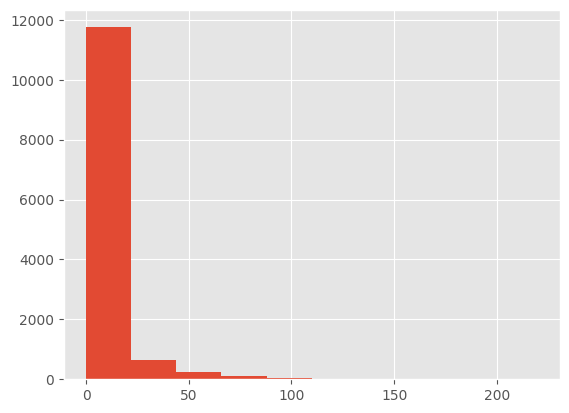

Standard quantiles: [  0.      1.195   3.374   7.996 219.599]
Mean: 8.220683101329808.


<AxesSubplot: >

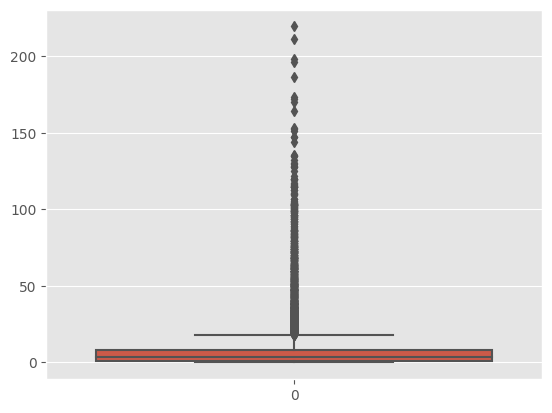

In [57]:
plt.hist(all["revenue"])
plt.show()

print(f'Standard quantiles: {np.quantile(train["revenue"], [0, 0.25, 0.5, 0.75, 1])}')
print(f'Mean: {np.mean(train["revenue"])}.')

sns.boxplot(train['revenue'])

**EDA insight 1**

The target distribution is extremely skewed. This is a problem as most of our models assume approximately normally distributed data. To deal with this we have decided to:

1. Transform the data to the log1 scale in order to lessen the skewness
2. Remove extreme values, namely those with with zero revenue and revenue greater than 100.

Both of these will be followed up later in the data cleanup section.

### 2.1.2 ``chain_name``

Based on the head of the data set it appears there might be quite a few Mc Donalds and Burger King restaurants in the data set. Let's quickly check just how many there are. If there are a lot of either we might be able to use that to engineer features and/or reduce data dimensionality.

In [58]:
mc_D_rows = all[all['chain_name'].str.contains('MCDONALD', na = False)]
print(f"Number of McDonald's restaurants in data set:", len(mc_D_rows), ".")

BK_rows = all[all['chain_name'].str.contains('BURGER KING', na = False)]
print(f"Number of Burger King restaurants in data set:", len(BK_rows), ".")

Number of McDonald's restaurants in data set: 7 .
Number of Burger King restaurants in data set: 20 .


So it appears there are not that many of either after all.

In addition to this we also tried looking at the subset of stores whose ``chain_name`` value was NaN. We noticed someone on Piazza pointed out that lots of stores have NaN-valued sales channels that can easily be brute-force imputed by looking at the store name (ie. setting ``chain_name`` to McDonald's if ``store_name`` contains McDonald's), but we were not able to come up with a solution to this that does not violate the competition's rules against defining high numbers of constants and/or using outside data.

## 2.2 Data cleanup

As can be seen from the plots, this is much more feasible for inference.

Removing rows with 0 revenue might seem dubious on principle. It does not help that, as mentioned earlier, we do not know exactly what unit ``revenue`` is measured in, so intuiting what exactly 0 revenue means is far from trivial.

In any case trial and error with submission scores, suggests removing these rows is an improvement, and so we have decided to do so.

As can be seen from the printout message, doing this luckily did not remove that many rows.

### 2.2.2 Using latest data

Some of the datasets have values from both 2015 and 2016. Since the train and test data were sampled in 2016, we decided to use the latest data possible, and remove the old data (which is then redundant). 
### 2.2.1 Remove extreme values

We have elected to trim away extreme values from ``revenue``, where we define an extreme value to be any value at exactly 0, or above 100.

Justifying this from a domain-knowledge or intuition standpoint is tricky. As we mentioned in the opening paragraph, we do not know for certain what ``revenue`` is, meaning we in turn do not know what 0 revenue means either.

The actual reason behind this decision is a bit more pragmatic; we found through trial and error on the Kaggle leaderboards that doing this improved our score, and so we decided it was probably a good decision.

In [59]:
def only_latest_data(df: pd.DataFrame):
    df = df.sort_values(by='year', ascending=False)
    df = df.drop_duplicates(subset='grunnkrets_id', keep='first')
    return df


spatial_latest = only_latest_data(spatial)
income_latest = only_latest_data(income)
households_latest = only_latest_data(households)

### 2.1.2 Imputing NaNs from merging

Another major problem with the data as-is is the high number of NaN values, particularly NaNs that arise because the stores in question have no match in the supplementary data sets, ie. ``age.csv``, ``spatial.csv``, ``income.csv`` and ``household.csv``. We have tried to remedy this with some imputations, for instance by replacing all NaNs from merging with ``spatial.csv`` with their own category, but we do not find that this helps with inference, so instead we simply remove these rows.

In [60]:
train.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


In [61]:
age_ranges = [
    (0, 19),
    (20, 39),
    (40, 59),
    (60, 79),
    (80, 90),
]

def clean_out_nan_heavy_rows(df: pd.DataFrame):
    """Cleans out rows that have no match in the age, spatial, income or household datasets."""

    # df2 = df.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')
    df2 = df.merge(spatial_latest.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(income_latest.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(households_latest.drop(columns=['year']), on='grunnkrets_id', how='left')
    print(len(df), df.columns)
    print(len(df2), df2.columns)

    df_cleaned = df[
        ~(df2.couple_children_0_to_5_years.isna() | df2.grunnkrets_name.isna() | df2.income_all_households.isna())  # | df2.age_0_19.isna() 
    ]

    print(f'Cleaned out {len(df) - len(df_cleaned)} out of {len(df)} rows.')

    return df_cleaned

train = clean_out_nan_heavy_rows(train)
label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8, random_state=SEED)

12859 Index(['store_id', 'year', 'store_name', 'plaace_hierarchy_id',
       'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon',
       'chain_name', 'mall_name', 'revenue'],
      dtype='object')
12859 Index(['store_id', 'year', 'store_name', 'plaace_hierarchy_id',
       'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon',
       'chain_name', 'mall_name', 'revenue', 'grunnkrets_name',
       'district_name', 'municipality_name', 'geometry', 'area_km2',
       'income_all_households', 'income_singles',
       'income_couple_without_children', 'income_couple_with_children',
       'income_other_households', 'income_single_parent_with_children',
       'couple_children_0_to_5_years', 'couple_children_18_or_above',
       'couple_children_6_to_17_years', 'couple_without_children',
       'single_parent_children_0_to_5_years',
       'single_parent_children_18_or_above',
       'single_parent_children_6_to_17_years', 'singles'],
      dtype='object')
Cleaned out 12

### 2.2.1 Remove extreme values

Length of data frame: 9947
Length after removing extreme values and zero revenue retail stores: 9947


<AxesSubplot: >

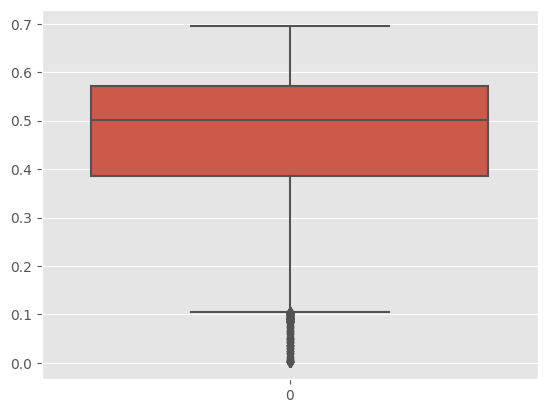

In [64]:
def clean(df: pd.DataFrame, min_val=0, max_val=100):
    print('Length of data frame:', len(df))
    df = df[(df.revenue > min_val) & (df.revenue < max_val)]
    print('Length after removing extreme values and zero revenue retail stores:',  len(df))
    # plt.hist(np.log1p(train.revenue), 30)
    # plt.show()
    return df.drop(columns=['revenue']), df.revenue

X_train, y_train = clean(pd.merge(X_train, y_train, left_index=True, right_index=True))
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

sns.boxplot(np.log1p(y_train))

Luckily, doing so removes very few rows, as can be seen from the printout. So it does not seem like a bad decision on principle. As can be seen from the plots, the overall shape of ``revenue`` has not changed much either, which further strengthens the hypothesis that this was a good decision.

### 2.1.2 Imputing NaNs from merging

Another major problem with the data as-is is the high number of NaN values, particularly NaNs that arise because the stores in question have no match in the supplementary data sets, ie. ``age.csv``, ``spatial.csv``, ``income.csv`` and ``household.csv``. We have tried to remedy this with some imputations, for instance by replacing all NaNs from merging with ``spatial.csv`` with their own category, but we do not find that this helps with inference, so instead we simply remove these rows.

<AxesSubplot: xlabel='revenue', ylabel='Count'>

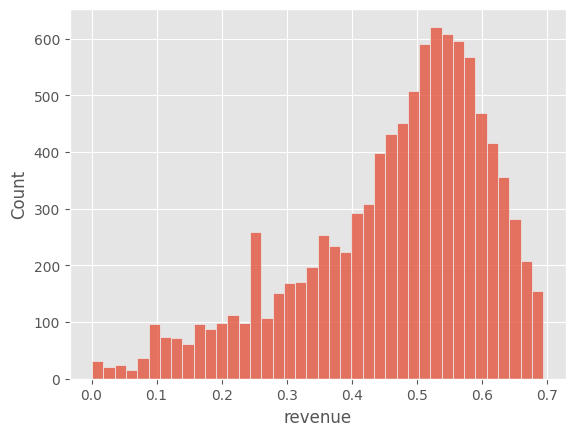

In [65]:
sns.histplot(np.log1p(y_train))

## 2.3 Understanding how the data was generated

To test some hypotheses about how the data set was split into test and training sets, we inspect the store IDs, but first, take note of the relative sizes of the raw training and test sets:

In [66]:
raw_train = pd.read_csv("data/stores_train.csv")
raw_test = pd.read_csv("data/stores_test.csv")
raw_total = pd.concat([raw_train, raw_test])

print(f"Size of training set: {len(raw_train)}.")
print(f"Size of test set: {len(raw_test)}.")
print(f"Ratio of test to train set size: {len(raw_test)/len(raw_train)}.")
print(f"Relative amount of training points: {len(raw_train)/len(raw_total)}")
print(f"Relative amount of testing points: {len(raw_test)/len(raw_total)}")

Size of training set: 12859.
Size of test set: 8577.
Ratio of test to train set size: 0.6670036550276072.
Relative amount of training points: 0.5998787087143124
Relative amount of testing points: 0.40012129128568763


We see that the respective proportions of training and test set are roughly 60/40. Were it not for this we could have guessed that stores were chosen based on modular-arithmetic operations on their IDs (ie. the test set could have consisted of every second, third, fourth store etc. after sorting them by ID).

To see if there might be some other trick at play, we can look at the distribution of ``store_id``.

In [67]:
raw_train["store_id"]

0         983540538-974187930-44774
1         987074191-973117734-44755
2         984890265-981157303-64491
3        914057442-992924179-126912
4        913018583-913063538-668469
                    ...            
12854    915789943-915806929-781991
12855    917921733-917982368-868081
12856    911721961-911764474-496764
12857    914337046-914343372-721294
12858    917494436-917551936-851089
Name: store_id, Length: 12859, dtype: object

We see that ``store_id`` is generally (if not categorically) a set of numbers separated by hyphens. Let's look at what they look like if we ``store_id`` into three different rows accordingly. We use log scale on column 3 because the histogram appears empty otherwise

In [68]:
# raw_total["store_id"].iloc[-2]
def split_store_id(df):
    id_col1 = []
    id_col2 = []
    id_col3 = []
    for i in range(len(df)):
        store_id_row = str(df["store_id"].iloc[i]).split("-")
        if len(store_id_row) > 3:
            indices_to_pop = []
            i = 0
            while len(store_id_row)-1 -i: #Not sure why, but some rows generates empty string elements, so we remove them here
                if not store_id_row[i]:
                    store_id_row.pop(i)
                else:
                    i += 1
        id_col1.append(int(store_id_row[0]))
        id_col2.append(int(store_id_row[1]))
        id_col3.append(int(store_id_row[2]))
    df["id_col1"] = id_col1
    df["id_col2"] = id_col2
    df["id_col3"] = id_col3
    return(df)

raw_total = split_store_id(raw_total)

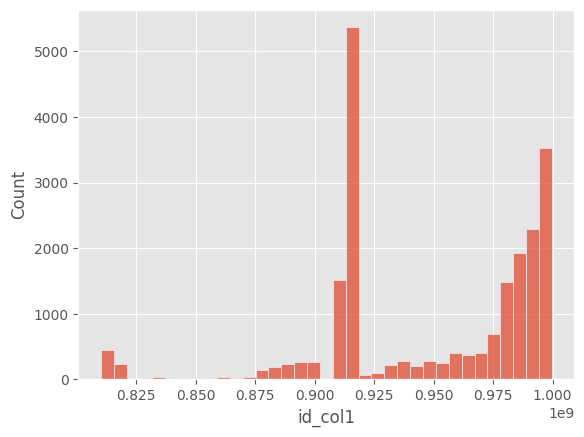

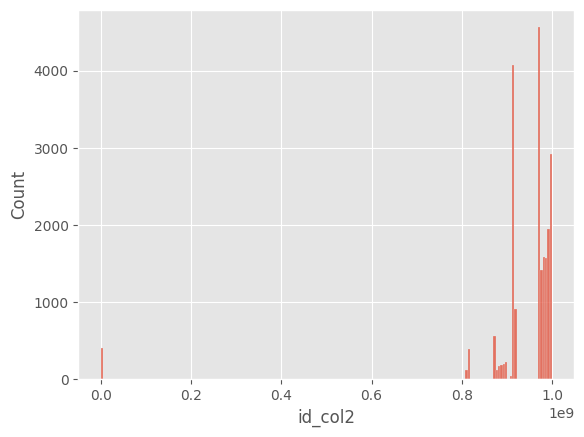

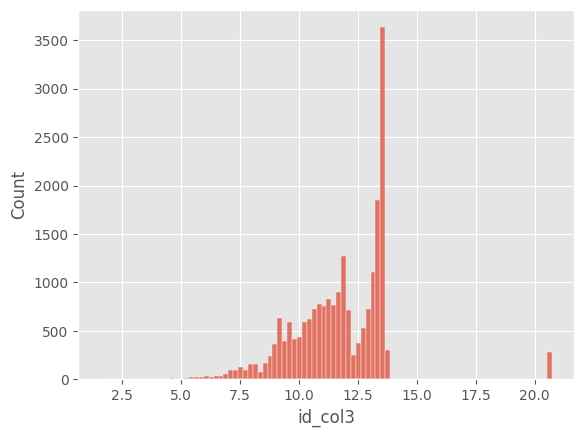

In [69]:
sns.histplot(raw_total["id_col1"])
plt.show()
sns.histplot(raw_total["id_col2"])
plt.show()
sns.histplot(np.log(raw_total["id_col3"]))
plt.show()

This seems interesting. From this we can see that the numbers are at least not uniformly random. It might be that store-id is chosen such that it has some qualitative information about the business in question, and we see distribution spikes because some types of businesses occur more than others.

These were the distributions for the complete data set. Let's quickly compare test and training set to see if any obvious differences appear then.

The shape of both histograms appear relatively similar, so we have nothing to support the hypothesis that ``store_id`` plays a role in data generation, at least not yet. The leading hypothesis is then that the training/test split was done at random.

## 2.4 Pairs and groups of variables

#### 2.4.1 ``lon``, ``lat`` and ``revenue``

Ideally, we want our data set to cover the entire country. Checking whether there is an obvious relationship between `lon` or `lat` and `revenue` would also be interesting. Finally, are there any glaring discrepancies between training and test sets in regards to these variables? We can quickly check for all of this with a couple of pairs plots:

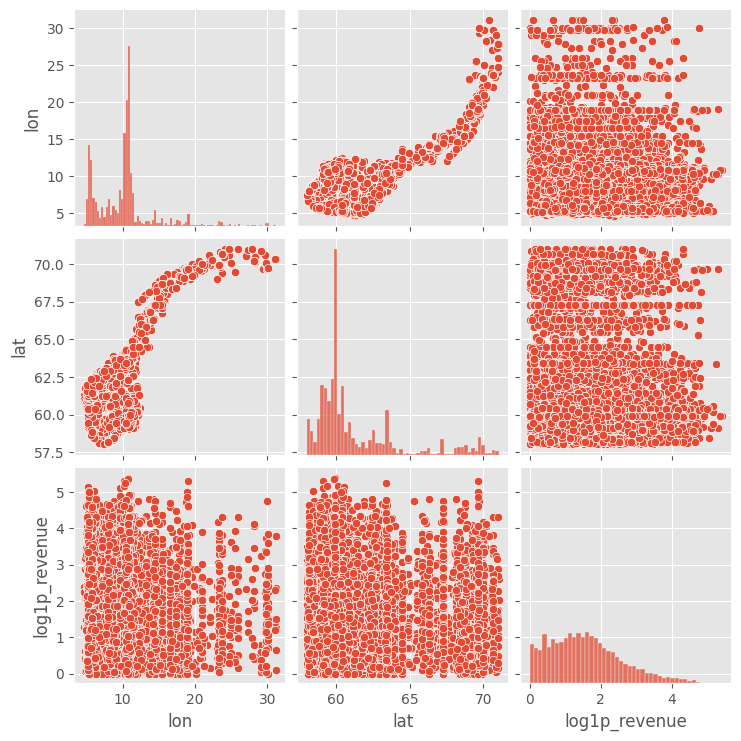

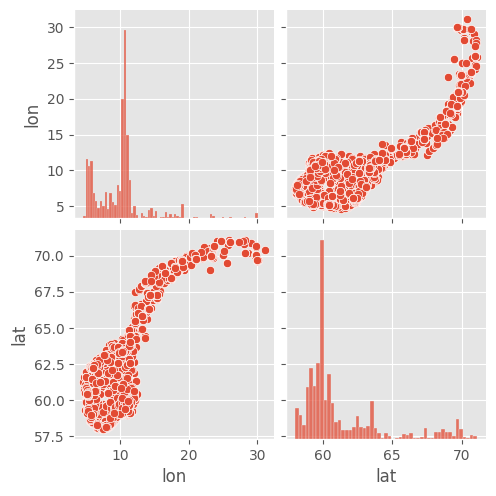

In [72]:
train["log1p_revenue"] = np.log1p(train["revenue"])
sns.pairplot(train, vars = ["lon", "lat", "log1p_revenue"])
sns.pairplot(test, vars = ["lon", "lat"])

From looking at the first plots of ``lat`` vs. ``lon`` we see that the dataset does indeed cover the entire country, as the collection of dots closely resembles a map of Norway. There also does not appear to be a glaring discrepancy between the test and training sets in regard to store locations, at least not any that can easily be seen from these plots.

Looking at the `lat` and `lon` histograms, the difference in geographical density becomes a lot more obvious. There are clearly far more stores near longitude 10 and latitude 60. From looking at the plots of ``lat``/``lon`` vs ``revenue`` we also see a relation to the skewness of ``revenue``, as
1. the ``revenue`` outlier values are found here, and
2. there seems to be more stores in the area overall.

We can look even closer at the difference between the test and training set, though, and one way of doing so is with a simple combined scatterplot of ``lon`` and ``lat``, this time with different colours for training and test set.

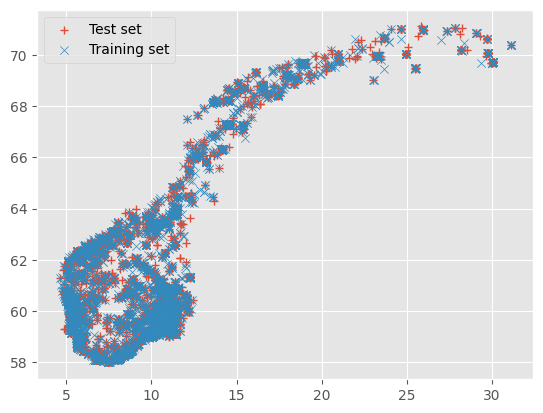

In [73]:
df_split_comparison = pd.concat([train, test])
df_split_comparison["Is_test"] = [False if i < len(train) else True for i in range(len(df_split_comparison))]

#sns.scatterplot(data = df_split_comparison, x = "lon", y = "lat", hue = "Is_test")

plt.scatter(test["lon"], test["lat"], linewidths=1, marker="+", label = "Test set")
plt.scatter(train["lon"], train["lat"], linewidths=0.5, marker="x", label = "Training set")
plt.legend()
plt.show()


This seems to de-confirm the hypothesis that there is an obvious geopgraphical component to the data set split method.

### 2.4.2 ``lon``, ``lat``, ``revenue`` and age groups

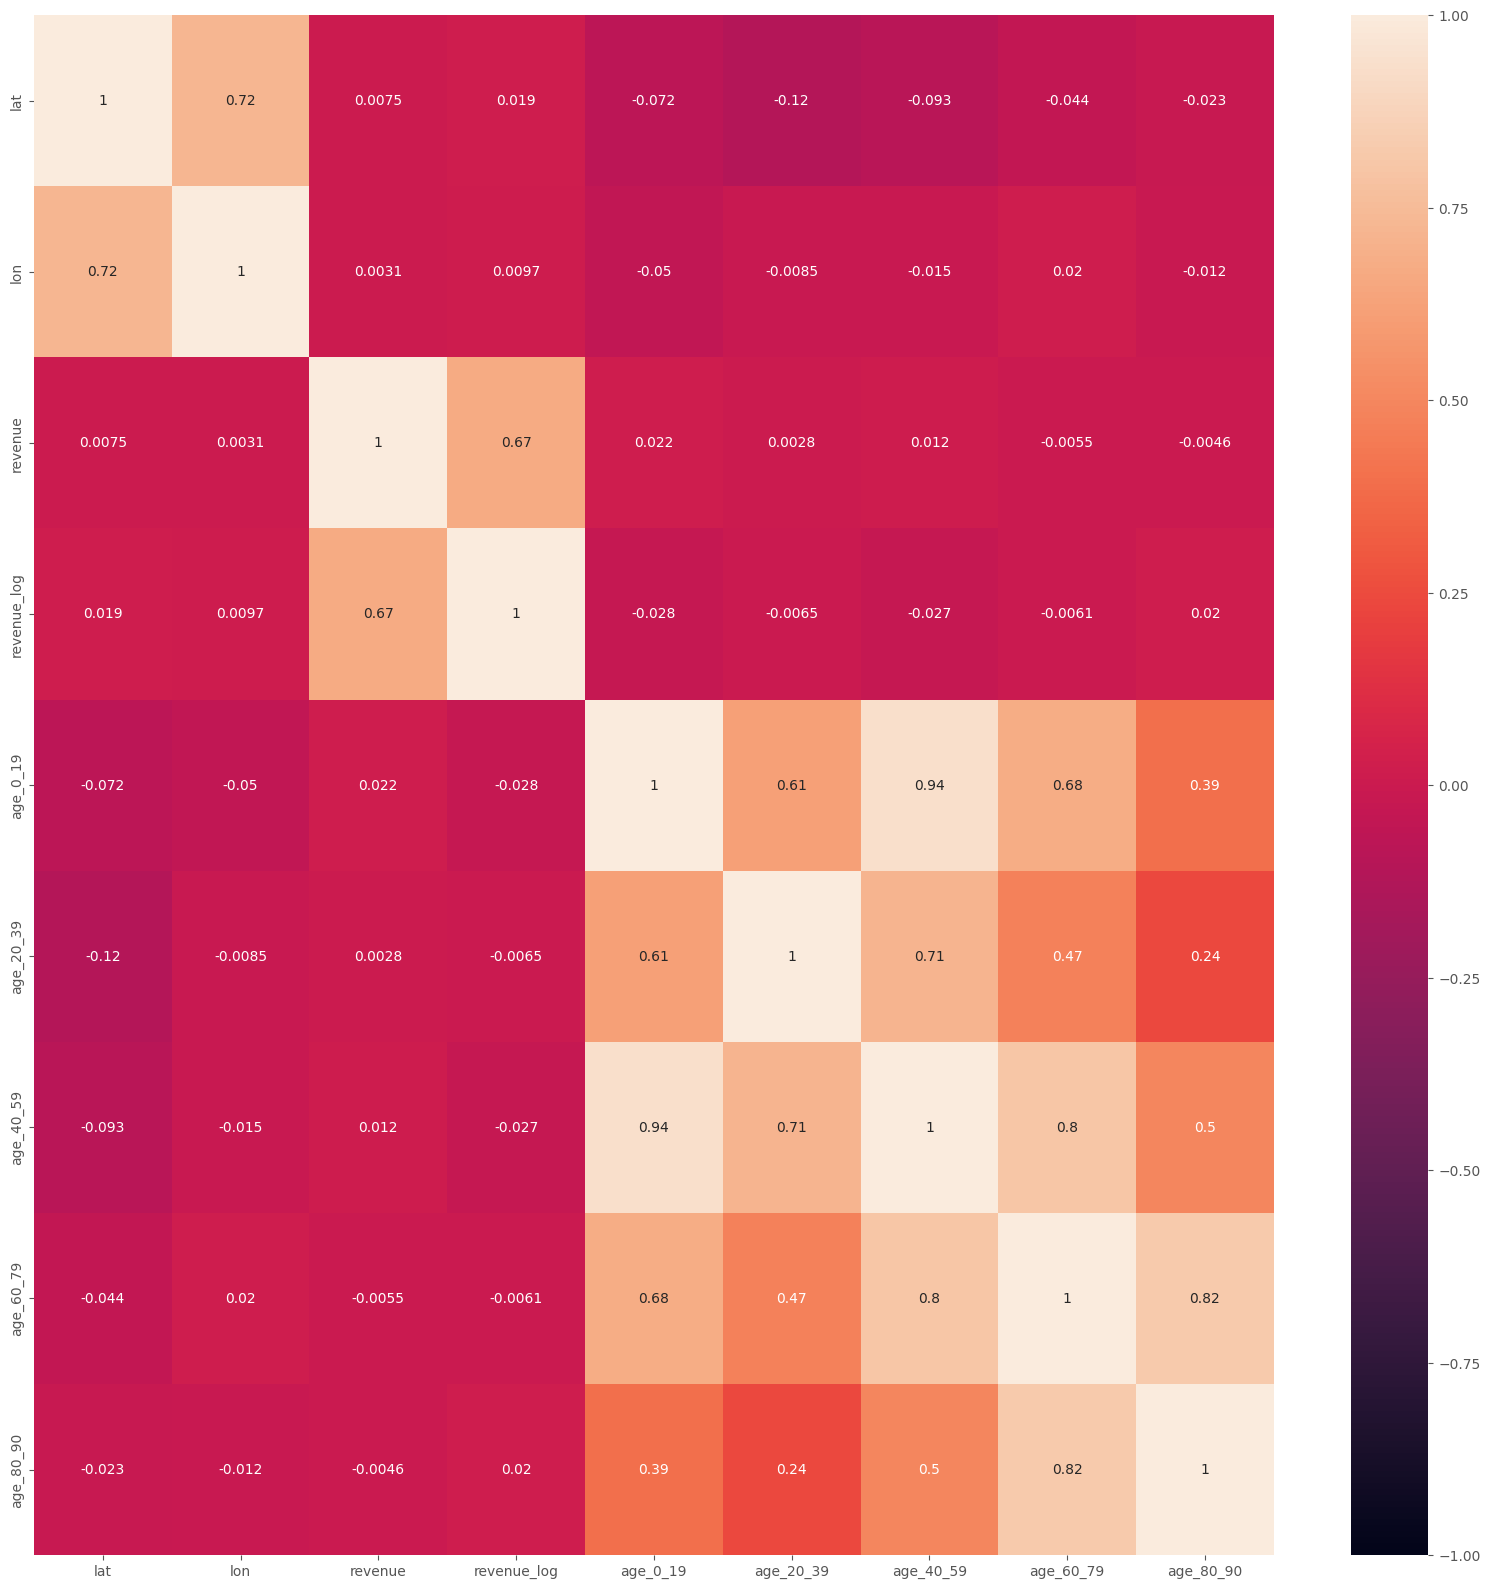

In [74]:
all['revenue_log'] = np.log(all['revenue'])

age_ranges = [
    (0, 19),
    (20, 39),
    (40, 59),
    (60, 79),
    (80, 90),
]

def group_ages(age: pd.DataFrame, age_ranges):
    """
    Simplifies an age distribution data set so that it only counts persons in given age intervals
    Input:
        age: A pandas dataframe of the same format as the original csv. data
        age_ranges: An array of tuples representing intervals by which to group people
    Output: A pandas age dataframe whose columns are are the number of people with ages in the respective interval.
    """
    
    age_new = age[['grunnkrets_id', 'year']].drop_duplicates(subset=['grunnkrets_id'], keep='last')

    for rng in age_ranges:
        cols = [f'age_{age}' for age in range(rng[0], rng[1] + 1)]
        rng_sum = age[cols].sum(axis=1).astype(int)
        age_new[f'age_{rng[0]}_{rng[-1]}'] = rng_sum

    age = age.drop_duplicates(subset='grunnkrets_id').drop(columns=['year', *(f'age_{age}' for age in range(0, 91))], axis=1)
    age = age.merge(age_new.drop(columns=['year']), on='grunnkrets_id')

    return age

all = all.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')

def plot_corr(data):
  df = data[['lat', 'lon', 'revenue', 'revenue_log', 'age_0_19', 'age_20_39', 'age_40_59', 'age_60_79', 'age_80_90']]
  plt.figure(figsize=(20, 20))
  
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plot_corr(all)

# all = all[~(all.age_0_19_x, all.age_0_19_y, all.age_20_39_x, all.age_20_39_y, all.age_40_59_x, all.age_40_59_x, all.age_40_59_y,
# all.age_60_79_x, all.age_60_79_y, all.age_80_90_x, all.age_80_90_y)]
all = all.drop("age_0_19", axis=1).drop("age_20_39", axis=1).drop("age_40_59", axis=1).drop("age_60_79", axis=1).drop("age_80_90", axis=1)
#all = all.drop(["age_0_19", "age_20_39", "age_40_59", "age_60_79", "age_80_90"])


This is a heatmap of latitude, longitude, revenue, logged revenue, age 0-19, age 20-39, age 40-59, age 60-79, age 80-90. Not surprisingly, the age groups have a high correlation. Specifically ages 80-90 and ages 60-79 have a high correlation, while age 80-90 have a low correlation with the ages of 20-39. The revenue has a low correlation with the age groups, and the latitude and longitude.

### 2.2.2 Distance from city centers using K means

### 2.2.3 Nearby bus stop counts

#### 2.2.4 Nearby store count

Following a line of reasoning as the K means clustering, we suspected the number other stores in a given radius might be a useful feature.The underlying hypothesis is more or less the same: When several stores are close together, that tends to be mean there are more costumers around to support them. Ergo counting the number of nearby stores might be useful for inference.

# Part 3: Feature engineering

## 3.2 Creation/engineering

### 3.1.1 Age

**Engineered feature 1: Age groups**

The ``plaace_hierarchy.csv`` data set very thoroughly categorises every single business in the data set. ``sales_channel_name`` presumably tries to do more or less the same, but clearly lacks the same "resolution", so is it redundant? Consider the following printout:

In [75]:
plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
all = all.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
all.head().T

,0,1,2,3,4
store_id,983540538-974187930-44774,987074191-973117734-44755,984890265-981157303-64491,914057442-992924179-126912,913018583-913063538-668469
year,2016,2016,2016,2016,2016
store_name,MCDONALD'S BRAGERNES TORG MAGASINET,MCDONALD'S KLINGENBERGGATA,BURGER KING HØNEFOSS,BURGER KING GLASSHUSPASSASJEN,BURGER KING TILLERTORGET
plaace_hierarchy_id,1.1.1.0,1.1.1.0,1.1.1.0,1.1.1.0,1.1.1.0
sales_channel_name_x,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants,Hamburger restaurants
grunnkrets_id,6020303,3010306,6050102,18040102,16017414
address,BRAGERNES TORG 13,NaN,KONG RINGS GATE 1,STORGATA 12,NaN
lat,59.743104,59.913759,60.164751,67.283669,63.358068
lon,10.204928,10.734031,10.254656,14.379796,10.374832
chain_name,MCDONALDS,MCDONALDS,BURGER KING,BURGER KING,BURGER KING


Note that the ``sales_channel_name``, ``lv3_desc`` and ``lv4_desc`` categories perfectly match for the rows in the printout. If this is not just a lucky coincidence, then we have good reason to rule out one or more of these as redundant.

In [76]:
sales_to_lv3_matches = len(all[all["sales_channel_name_x"] == all["lv3_desc"]])
sales_to_lv4_matches = len(all[all["sales_channel_name_x"] == all["lv4_desc"]])
lv3_to_lv4_matches = len(all[all["lv3_desc"] == all["lv4_desc"]])

N = len(all)


print(f"Number of matches between sales channel and lv3 description: {sales_to_lv3_matches}.",
    f"Corresponding percentage: {round(sales_to_lv3_matches/N, 3)*1e2}")
print(f"Number of matches between sales channel and lv4 description: {sales_to_lv4_matches}.",
    f"Corresponding percentage {round(sales_to_lv4_matches/N, 3)*1e2}.")
print(f"Number of matches between lv3 and lv4 descriptions: {lv3_to_lv4_matches}.",
    f"Corresponding percentage: {round(lv3_to_lv4_matches/N, 3)*1e2}.")

Number of matches between sales channel and lv3 description: 18353. Corresponding percentage: 85.6
Number of matches between sales channel and lv4 description: 21248. Corresponding percentage 99.1.
Number of matches between lv3 and lv4 descriptions: 18421. Corresponding percentage: 85.9.


### 3.1.2 Distance to city center

In [79]:
def meter_distance(lat1, lon1, lat2, lon2):
    line_string = LineString([Point(lon1, lat1), Point(lon2, lat2)])
    geod = Geod(ellps="WGS84")
    return geod.geometry_length(line_string)


def add_city_centre_dist(X: pd.DataFrame):
    old_shape = X.shape

    city_centres = X.groupby(['municipality_name'])[['lat', 'lon']].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']]
    X = X.merge(city_centres, on=['municipality_name'], how='left', suffixes=(None, '_center'))
    assert X.shape[0] == old_shape[0]

    X.fillna(value={'lat_center': X.lat, 'lon_center': X.lon}, inplace=True)

# Part 3: Feature engineering

In [80]:
def create_busstops_files():
    """
    Creates a .parquet file that stores info aboute the number of busstops within a 1 kilometer
    radius of a given store, as well as the number of stops within the different importance categories.  
    """

    def bus_fields(row: pd.Series):
        output_dict = {}
        gpd.options.use_pygeos = True
        
        stops_with_dist = busstops[busstops_geo.distance(row.geometry) < 1000]
        output_dict['bus_stops_count'] = len(stops_with_dist)
        
        output_dict.update(stops_with_dist.importance_level.value_counts().reindex(
            busstops_geo.importance_level.unique(), fill_value=0
        ).to_dict())
        
        return output_dict

    train_with_extras_bus = pd.concat([train_geo, train_geo_extra], ignore_index=True)

    train_with_extras_bus = train_with_extras_bus.join(train_with_extras_bus.progress_apply(lambda row: bus_fields(row), axis=1, result_type='expand'))
    train_with_extras_bus.to_parquet('derived_data/stores_bus_stops_lt_1km_train.parquet')

    test_bus = test_geo.join(test_geo.progress_apply(lambda row: bus_fields(row), axis=1, result_type='expand'))
    test_bus.to_parquet('derived_data/stores_bus_stops_lt_1km_test.parquet')

### 3.1.4 Stores in vicinity

In [81]:
def create_stores_in_vicinity_files():
    """
    Creates a .parquet file that stores info aboute the number of other stores within a 1 kilometer
    radius of a given store.
    """

    train_with_extras = pd.concat([train_geo, train_geo_extra], ignore_index=True)[['store_id', 'geometry']]

    def store_count_in_vicinity(row: pd.Series):
        stores_in_vicinity = train_with_extras[train_with_extras.distance(row.geometry) < 1000]
        return {'stores_count_lt_1km': len(stores_in_vicinity)}

    train_with_extras_vicinity = train_with_extras.join(train_with_extras.progress_apply(lambda row: store_count_in_vicinity(row), axis=1, result_type='expand'))
    train_with_extras_vicinity.to_parquet('derived_data/stores_count_lt_1km_train.parquet')

    test_vicinity = test_geo.join(test_geo.progress_apply(lambda row: store_count_in_vicinity(row), axis=1, result_type='expand'))
    test_vicinity.to_parquet('derived_data/stores_count_lt_1km_test.parquet')

### 3.1.5 DBSCAN

In [ ]:
def add_spatial_clusters(df: pd.DataFrame):
    clusters = DBSCAN(eps=0.145, min_samples=100)
    # clusters = DBSCAN(eps=0.12, min_samples=30)
    cl = clusters.fit_predict(df[['lat', 'lon']].to_numpy())
    cl_counts = dict(zip(*np.unique(cl, return_counts=True)))

    print(len(set(cl)), 'clusters created')
    print('Cluster counts:', cl_counts)

    df['cluster_id'] = cl
    df['cluster_member_count'] = df.apply(lambda row: cl_counts[row.cluster_id], axis=1)

    X_no_outliers = df[df.cluster_id != -1]
    cluster_centroids = X_no_outliers.groupby('cluster_id')[['lat', 'lon']].mean()

    def closest_centroid(lat, lon):
        dist_series = cluster_centroids.apply(lambda row: meter_distance(lat, lon, row.lat, row.lon), axis=1)
        return dist_series.min()

    print('Calculating distance to closest cluster for each data point...')
    df['closest_cluster_centroid_dist'] = df.progress_apply(lambda row: closest_centroid(row.lat, row.lon), axis=1)
    
    return df


train_test_clustered = add_spatial_clusters(pd.concat([train.drop(columns=['revenue']), test], axis=0).reset_index())
train_test_clustered = train_test_clustered[['store_id', 'cluster_id', 'cluster_member_count', 'closest_cluster_centroid_dist']]

train = train.merge(train_test_clustered, on='store_id', how='left')
test = test.merge(train_test_clustered, on='store_id', how='left')

## 3.2 Feature generation

In [85]:
spatial_latest = only_latest_data(spatial)
income_latest = only_latest_data(income)
households_latest = only_latest_data(households)

In [86]:
!mkdir -p derived_data

if len(os.listdir('derived_data')) == 0:
    create_busstops_files()
    create_stores_in_vicinity_files()

In [87]:
def generate_features(df: pd.DataFrame, data_origin: str, predictor: str = ''):
    # Define datasets to be merged
    age_groups_merge = group_ages(age, age_ranges)
    spatial_merge = spatial_latest.drop(columns=['year'])
    income_merge = income_latest.drop(columns=['year'])
    households_merge = households_latest.drop(columns=['year'])
    plaace_merge = plaace.drop_duplicates(subset='plaace_hierarchy_id')
    bus_data_train_merge = gpd.read_parquet(f'derived_data/stores_bus_stops_lt_1km_{data_origin}.parquet').drop(columns=['geometry'])
    stores_vicinity_merge = gpd.read_parquet(f'derived_data/stores_count_lt_1km_{data_origin}.parquet').drop(columns=['geometry'])

    # Merge datasets
    df = df.merge(age_groups_merge, on='grunnkrets_id', how='left')
    df = df.merge(spatial_merge, on='grunnkrets_id', how='left')
    df = df.merge(income_merge, on='grunnkrets_id', how='left')
    df = df.merge(households_merge, on='grunnkrets_id', how='left')
    df = df.merge(plaace_merge, how='left')
    df = df.merge(bus_data_train_merge, on='store_id', how='left')
    df = df.merge(stores_vicinity_merge, on='store_id', how='left')
    df = add_city_centre_dist(df).drop(columns=['lon_center', 'lat_center'])

    # Transformations and some post-merge cleaning
    df.stores_count_lt_1km = np.log(df.stores_count_lt_1km)
    df[age_groups_merge.columns] = df[age_groups_merge.columns].fillna(0)
    
    # Handle categories for different predictors
    if predictor == 'xgb':
        df = object_encoder(df)
    elif predictor == 'cb':
        df = nan_to_string(df)
    elif predictor == 'lgb':
        df = to_categorical(df)
    else: 
        raise ValueError('Invalid predictor')

    features = [
        'store_name', 
        'mall_name', 
        'chain_name',
        'address', 
        'lat', 'lon',
        
        *age_groups_merge.drop(columns=['grunnkrets_id']).columns,
        *income_merge.drop(columns=['grunnkrets_id']).columns,
        *households_merge.drop(columns=['grunnkrets_id']).columns,
        'lv1_desc', 'lv2_desc', 'sales_channel_name', 
        *bus_data_train_merge.drop(columns=['store_id']).columns,
        *stores_vicinity_merge.drop(columns=['store_id']).columns,
        'dist_to_center',
    ]

    return df[features]

## 3.3 Other attempts

#### 3.3.1 Combining features

age.head()

To use this data as-is is clearly undesirable. Doing so would run into the curse of dimensionality, especially considering this problem overall already has a high number of potential variables/features.

Intuitively, the level of resolution present here is redundant. One would for instance not expect a substantially different impact from children aged 6 compared to children aged 10, or from adults aged 25 to 27, for instance. Therefore we instead make use of the following age groups:

In [88]:
age_ranges = [
    (0, 19),
    (20, 39),
    (40, 59),
    (60, 79),
    (80, 90),
]

def group_ages(age: pd.DataFrame, age_ranges):
    """
    Simplifies an age distribution data set so that it only counts persons in given age intervals
    Input:
        age: A pandas dataframe of the same format as the original csv. data
        age_ranges: An array of tuples representing intervals by which to group people
    Output: A pandas age dataframe whose columns are are the number of people with ages in the respective interval.
    """
    
    age_new = age[['grunnkrets_id', 'year']].drop_duplicates(subset=['grunnkrets_id'], keep='last')

    for rng in age_ranges:
        cols = [f'age_{age}' for age in range(rng[0], rng[1] + 1)]
        rng_sum = age[cols].sum(axis=1).astype(int)
        age_new[f'age_{rng[0]}_{rng[-1]}'] = rng_sum

    age = age.drop_duplicates(subset='grunnkrets_id').drop(columns=['year', *(f'age_{age}' for age in range(0, 91))], axis=1)
    age = age.merge(age_new.drop(columns=['year']), on='grunnkrets_id')

    return age

all = all.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')

Through trial and error with our models, we also found that this improves inference, as expected.

### 3.1.2 Distance to city center

In [89]:
def meter_distance(lat1, lon1, lat2, lon2):
    line_string = LineString([Point(lon1, lat1), Point(lon2, lat2)])
    geod = Geod(ellps="WGS84")
    return geod.geometry_length(line_string)


def add_city_centre_dist(X: pd.DataFrame):
    old_shape = X.shape

    city_centres = X.groupby(['municipality_name'])[['lat', 'lon']].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']]
    X = X.merge(city_centres, on=['municipality_name'], how='left', suffixes=(None, '_center'))
    assert X.shape[0] == old_shape[0]

    X.fillna(value={'lat_center': X.lat, 'lon_center': X.lon}, inplace=True)

    X['dist_to_center'] = X.apply(lambda row: meter_distance(row.lat, row.lon, row.lat_center, row.lon_center), axis=1)
    assert X.shape[0] == old_shape[0]

    return X

### 3.1.3 Busstops

In [90]:
def create_busstops_files():
    """
    Creates a .parquet file that stores info aboute the number of busstops within a 1 kilometer
    radius of a given store, as well as the number of stops within the different importance categories.  
    """

    def bus_fields(row: pd.Series):
        output_dict = {}
        gpd.options.use_pygeos = True
        
        stops_with_dist = busstops[busstops_geo.distance(row.geometry) < 1000]
        output_dict['bus_stops_count'] = len(stops_with_dist)
        
        output_dict.update(stops_with_dist.importance_level.value_counts().reindex(
            busstops_geo.importance_level.unique(), fill_value=0
        ).to_dict())
        
        return output_dict

    train_with_extras_bus = pd.concat([train_geo, train_geo_extra], ignore_index=True)

    train_with_extras_bus = train_with_extras_bus.join(train_with_extras_bus.progress_apply(lambda row: bus_fields(row), axis=1, result_type='expand'))
    train_with_extras_bus.to_parquet('derived_data/stores_bus_stops_lt_1km_train.parquet')

    test_bus = test_geo.join(test_geo.progress_apply(lambda row: bus_fields(row), axis=1, result_type='expand'))
    test_bus.to_parquet('derived_data/stores_bus_stops_lt_1km_test.parquet')




### 3.1.4 Stores in vicinity

Following a line of reasoning as the K means clustering, we suspected the number other stores in a given radius might be a useful feature.The underlying hypothesis is more or less the same: When several stores are close together, that tends to be mean there are more costumers around to support them. Ergo counting the number of nearby stores might be useful for inference.

In [91]:
def create_stores_in_vicinity_files():
    """
    Creates a .parquet file that stores info aboute the number of other stores within a 1 kilometer
    radius of a given store.
    """

    train_with_extras = pd.concat([train_geo, train_geo_extra], ignore_index=True)[['store_id', 'geometry']]

    def store_count_in_vicinity(row: pd.Series):
        stores_in_vicinity = train_with_extras[train_with_extras.distance(row.geometry) < 1000]
        return {'stores_count_lt_1km': len(stores_in_vicinity)}

    train_with_extras_vicinity = train_with_extras.join(train_with_extras.progress_apply(lambda row: store_count_in_vicinity(row), axis=1, result_type='expand'))
    train_with_extras_vicinity.to_parquet('derived_data/stores_count_lt_1km_train.parquet')

    test_vicinity = test_geo.join(test_geo.progress_apply(lambda row: store_count_in_vicinity(row), axis=1, result_type='expand'))
    test_vicinity.to_parquet('derived_data/stores_count_lt_1km_test.parquet')

### 3.1.5 DBSCAN

In [92]:
def add_spatial_clusters(df: pd.DataFrame):
    clusters = DBSCAN(eps=0.145, min_samples=100)
    # clusters = DBSCAN(eps=0.12, min_samples=30)
    cl = clusters.fit_predict(df[['lat', 'lon']].to_numpy())
    cl_counts = dict(zip(*np.unique(cl, return_counts=True)))

    print(len(set(cl)), 'clusters created')
    print('Cluster counts:', cl_counts)

    df['cluster_id'] = cl
    df['cluster_member_count'] = df.apply(lambda row: cl_counts[row.cluster_id], axis=1)

    X_no_outliers = df[df.cluster_id != -1]
    cluster_centroids = X_no_outliers.groupby('cluster_id')[['lat', 'lon']].mean()

    def closest_centroid(lat, lon):
        dist_series = cluster_centroids.apply(lambda row: meter_distance(lat, lon, row.lat, row.lon), axis=1)
        return dist_series.min()

    print('Calculating distance to closest cluster for each data point...')
    df['closest_cluster_centroid_dist'] = df.progress_apply(lambda row: closest_centroid(row.lat, row.lon), axis=1)
    
    return df

## 3.2 Feature generation

In [93]:
spatial_latest = only_latest_data(spatial)
income_latest = only_latest_data(income)
households_latest = only_latest_data(households)

In [94]:
!mkdir -p derived_data

if len(os.listdir('derived_data')) == 0:
    create_busstops_files()
    create_stores_in_vicinity_files()

In [95]:
def generate_features(df: pd.DataFrame, data_origin: str, predictor: str = ''):
    # Define datasets to be merged
    age_groups_merge = group_ages(age, age_ranges)
    spatial_merge = spatial_latest.drop(columns=['year'])
    income_merge = income_latest.drop(columns=['year'])
    households_merge = households_latest.drop(columns=['year'])
    plaace_merge = plaace.drop_duplicates(subset='plaace_hierarchy_id')
    bus_data_train_merge = gpd.read_parquet(f'derived_data/stores_bus_stops_lt_1km_{data_origin}.parquet').drop(columns=['geometry'])
    stores_vicinity_merge = gpd.read_parquet(f'derived_data/stores_count_lt_1km_{data_origin}.parquet').drop(columns=['geometry'])

    # Merge datasets
    df = df.merge(age_groups_merge, on='grunnkrets_id', how='left')
    df = df.merge(spatial_merge, on='grunnkrets_id', how='left')
    df = df.merge(income_merge, on='grunnkrets_id', how='left')
    df = df.merge(households_merge, on='grunnkrets_id', how='left')
    df = df.merge(plaace_merge, how='left')
    df = df.merge(bus_data_train_merge, on='store_id', how='left')
    df = df.merge(stores_vicinity_merge, on='store_id', how='left')
    df = add_city_centre_dist(df).drop(columns=['lon_center', 'lat_center'])

    # Transformations and some post-merge cleaning
    df.stores_count_lt_1km = np.log(df.stores_count_lt_1km)
    df[age_groups_merge.columns] = df[age_groups_merge.columns].fillna(0)
    
    # Handle categories for different predictors
    if predictor == 'xgb':
        df = object_encoder(df)
    elif predictor == 'cb':
        df = nan_to_string(df)
    elif predictor == 'lgb':
        df = to_categorical(df)
    else: 
        raise ValueError('Invalid predictor')

    features = [
        'store_name', 
        'mall_name', 
        'chain_name',
        'address', 
        'lat', 'lon',
        
        *age_groups_merge.drop(columns=['grunnkrets_id']).columns,
        *income_merge.drop(columns=['grunnkrets_id']).columns,
        *households_merge.drop(columns=['grunnkrets_id']).columns,
        'lv1_desc', 'lv2_desc', 'sales_channel_name', 
        *bus_data_train_merge.drop(columns=['store_id']).columns,
        *stores_vicinity_merge.drop(columns=['store_id']).columns,
        'dist_to_center'
    ]

    return df[features]

## 3.3 Other attempts

#### 3.3.1 Combining features

When plotting feature importance, we saw that store_name had the biggest importance. We figured that maybe we could try combining store_name with other variables, to improve score. This did not work, however, or had minimal impact.

In [96]:
df_other = all.copy()

df_other['store_name_address'] = (df_other['store_name'].astype(str) + df_other['address'].astype(str)).astype('category')
df_other['store_name_lat'] = (df_other['store_name'].astype(str) + df_other['lat'].astype(str)).astype('category')
df_other['store_name_lon'] = (df_other['store_name'].astype(str) + df_other['lon'].astype(str)).astype('category')

# Part 4: Models and hyperparameter tuning

## 4.1 Hyperparameter tuning

As hyperparamater tuning is extremely important for a model to function optimally, we used libraries that did the tuning for us. We used random k fold with RandomizedSearchCV, and split our dataset into 80% train and 20% validation. By running this model, we found the most optimal parameters, we thought. As random k fold had its limitations, so we opted for Optuna instead, that gave even better hyperparameters. Here is an example of our Optuna model working:

| Trial                           | RMSLE score         | Parameters                                                                                                                                                                                         | Best Trial                                      |
|---------------------------------|---------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------|
| Trial 197 finished with value:  | 0.7203855872925886  | and parameters: {'lambda_l1': 2.7625726622938257e-06, 'lambda_l2': 5.974059396329312, 'num_leaves': 7, 'feature_fraction': 0.9540381054695006, 'min_child_samples': 96, 'boosting_type': 'gbdt'}.  | Best is trial 67 with value: 0.720211809513416. |
| Trial 198 finished with value:  | 0.7244371834775267  | and parameters: {'lambda_l1': 3.370376083398259e-06, 'lambda_l2': 6.587299063520444, 'num_leaves': 19, 'feature_fraction': 0.9570930427207726, 'min_child_samples': 100, 'boosting_type': 'gbdt'}. | Best is trial 67 with value: 0.720211809513416. |

The model ran several trials i.e. runs, with different hyperparameters. We used the hyperparameters from the best trial.
As embedding is one way to deal with categorical data, we wanted to try it out. We thought that stores with similar names could be interpreted "better" by the models by doing this. Sadly, it proved to do the opposite, and score got drastically worse. Why this is, we don't know. Maybe we could have experimented with more dimensions, or with different features, as we only attempted to do embedding on store_name.

In [ ]:
#### 3.3.2 Embedding
card_docs = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(df_other.store_name)]
    
doc2vec_model = Doc2Vec(min_count=1, vector_size=5, workers=4, epochs=40)
doc2vec_model.build_vocab(card_docs)
doc2vec_model.train(card_docs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
card2vec = [doc2vec_model.infer_vector((df_other['store_name'][i].split(' '))) for i in range(0, len(df_other['store_name']))]

dtv = np.array(card2vec)
df_other['store_name_embedded1'] = dtv[:, 0]
df_other['store_name_embedded2'] = dtv[:, 1]
df_other['store_name_embedded3'] = dtv[:, 2]
df_other['store_name_embedded4'] = dtv[:, 3]
df_other['store_name_embedded5'] = dtv[:, 4]
df = df_other.drop(columns=['store_name'])


Here are some functions that are used in the Optuna `objective` function to provide necessary data structures and hyperparameters for the different models.

#### Preparing DMatrices and parameter grid for XGBoost

In [98]:
# Features adapted to XGBoost
X_train_xgb = generate_features(X_train, data_origin='train', predictor='xgb')
X_val_xgb = generate_features(X_val, data_origin='train', predictor='xgb')
X_test_xgb = generate_features(test, data_origin='test', predictor='xgb')

def get_xgb_dmatrices():
    dtrain = xgb.DMatrix(data=X_train_xgb, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(data=X_val_xgb, label=y_val, enable_categorical=True)
    # dtest = xgb.DMatrix(data=X_test_xgb, enable_categorical=True)
    return dtrain, dvalid, None #


def get_xgb_params(trial: optuna.Trial = None):
    non_tunable_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'disable_default_eval_metric': True,
        'seed': SEED
    }

    if trial is None:
        return 'xgb', non_tunable_params

    tunable_params = {
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        # 'n_estimators': trial.suggest_int('n_estimators', 150, 350),
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'max_depth': trial.suggest_int('max_depth', 4, 9)
    }

    return 'xgb', non_tunable_params, tunable_params

#### Preparing pools and parameter grid for Catboost

In [99]:
# Features adapted to Catboost
X_train_cb = generate_features(X_train, data_origin='train', predictor='cb')
X_val_cb = generate_features(X_val, data_origin='train', predictor='cb')
X_test_cb = generate_features(test, data_origin='test', predictor='cb')


def get_cb_pools():
    text_features = ['store_name', 'address', 'sales_channel_name'] 
    cat_features = ['mall_name', 'chain_name', 'lv1_desc', 'lv2_desc']

    train_pool = cb.Pool(
        X_train_cb,
        y_train,
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train_cb)
    )

    valid_pool = cb.Pool(
        X_val_cb,
        y_val,
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train_cb)
    )

    return train_pool, valid_pool


def get_cb_params(trial: optuna.Trial = None):
    gpu_count = get_gpu_device_count()
    non_tunable_cb_params = {
        'objective': 'RMSE',
        'eval_metric': 'RMSE',
        'task_type': 'GPU' if gpu_count else 'CPU', 
        'devices': f'0:{gpu_count}',
        'random_seed': SEED
    }

    if trial is None:
        return 'cb', non_tunable_cb_params
    
    tunable_params = {
        'depth': trial.suggest_int('depth', 4, 9),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 6),
        # 'iterations': trial.suggest_int('iterations', 1000, 2000),
        # 'learning_rate': trial.suggest_categorical('learning_rate', 0.1, 0.5)
    }

    return 'cb', non_tunable_cb_params, tunable_params

#### Preparing DMatrices and parameter grid for LightGBM

In [100]:
# Features adapted to LightGBM
X_train_lgb = generate_features(X_train, data_origin='train', predictor='lgb')
X_val_lgb = generate_features(X_val, data_origin='train', predictor='lgb')
X_test_lgb = generate_features(test, data_origin='test', predictor='lgb')

def get_lgb_dmatrices():
    dtrain = lgb.Dataset(X_train_lgb, y_train, params={'verbose': -1}, free_raw_data=False)
    dvalid = lgb.Dataset(X_val_lgb, y_val, params={'verbose': -1}, free_raw_data=False)
    return dtrain, dvalid


def get_lgb_params(trial: optuna.Trial = None):
    non_tunable_lgb_params = {
        'objective': 'rmse',
        'verbose': -1,
        'seed': 1
    }

    if trial is None:
        return 'lgb', non_tunable_lgb_params

    tunable_params = {
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
    }

    if tunable_params['boosting_type'] != 'goss':
        tunable_params["bagging_fraction"]: trial.suggest_float("bagging_fraction", 0.4, 1.0)
        tunable_params["bagging_freq"]: trial.suggest_int("bagging_freq", 1, 7)

    return 'lgb', non_tunable_lgb_params, tunable_params

In [101]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def objective(trial: optuna.Trial, param_grid_fn: Callable) -> float:
    model_name, non_tunable_params, tunable_params = param_grid_fn(trial)

    if model_name == 'cb':
        if tunable_params['bootstrap_type'] == 'Bayesian': 
            tunable_params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
        elif tunable_params['bootstrap_type'] == 'Bernoulli':
            tunable_params['subsample'] = trial.suggest_float('subsample', 0.1, 1, log=True)

        cbr = cb.CatBoostRegressor(**non_tunable_params, **tunable_params) 
        train_pool, valid_pool = get_cb_pools()
        cbr.fit(
            train_pool,
            eval_set=[(X_val_cb, y_val)],
            verbose=0,
            early_stopping_rounds=100,
        )
        y_pred = cbr.predict(X_val_cb)
    
    elif model_name == 'lgb':
        dtrain_lgb, dvalid_lgb = get_lgb_dmatrices()
        lgbr = lgb.train(
            params={**non_tunable_params, **tunable_params},
            train_set=dtrain_lgb,
            valid_sets=dvalid_lgb,
            verbose_eval=False,
        )
        y_pred = lgbr.predict(X_val_lgb)

    score = rmsle(np.expm1(y_val), np.expm1(y_pred))

    return score


def get_hyper_parameters(param_grid_fn: Callable, n_trials=100):
    study = optuna.create_study(
        study_name='hyperparam-tuning',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction='minimize'
    )
    objective_fn = lambda trial: objective(trial, param_grid_fn)
    study.optimize(objective_fn, n_trials=n_trials, timeout=900) 

    print('Number of finished trials: {}'.format(len(study.trials)))
    
    trial = study.best_trial
    print(f'Best trial ({trial.number}):')
    print('Value:', trial.value)
    print('Params:')
    print(trial.params)

    return param_grid_fn()[1], trial.params

## 4.2 Models

### 4.2.1 XGBoost

The first model our group used was XGBoost. One of our group members has done some machine learning before, and had good results with XGBoost.  However, after a certain point in feature engineering, we were unable to make improvements to our validation score. Our results were fluctuating a lot, as well. We figured out it was time to try out a new model at this point.

In [102]:
# Features adapted to XGBoost
X_train_xgb = generate_features(X_train, data_origin='train', predictor='xgb')
X_val_xgb = generate_features(X_val, data_origin='train', predictor='xgb')
X_test_xgb = generate_features(test, data_origin='test', predictor='xgb')

def get_xgb_dmatrices():
    dtrain = xgb.DMatrix(data=X_train_xgb, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(data=X_val_xgb, label=y_val, enable_categorical=True)
    # dtest = xgb.DMatrix(data=X_test_xgb, enable_categorical=True)
    return dtrain, dvalid, None #


def get_xgb_params(trial: optuna.Trial = None):
    non_tunable_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'disable_default_eval_metric': True,
        'seed': SEED
    }

    if trial is None:
        return 'xgb', non_tunable_params

    tunable_params = {
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        # 'n_estimators': trial.suggest_int('n_estimators', 150, 350),
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'max_depth': trial.suggest_int('max_depth', 4, 9)
    }

    return 'xgb', non_tunable_params, tunable_params


### 4.2.2 Catboost

Our second model used was Catboost. Our reasoning is simple: we wanted to try a new model, and an article suggested catboost. Apparently it could outperform XGBoost in some cases. This is where we had our biggest jumps in the kaggle scoreboard.

In [103]:
non_tunable_cb_params, tuned_params = get_hyper_parameters(get_cb_params, n_trials=5)
train_pool, valid_pool = get_cb_pools()
cbm = cb.CatBoostRegressor(**non_tunable_cb_params, **tuned_params, iterations=1000) 
cbm.fit(train_pool, eval_set=valid_pool, verbose=50, plot=True, early_stopping_rounds=50)

[I 2022-11-13 17:17:04,292] A new study created in memory with name: hyperparam-tuning
[W 2022-11-13 17:17:14,457] Trial 0 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "/home/koholm/Desktop/maskinprosjekt/venv/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1687476/4073316833.py", line 44, in <lambda>
    objective_fn = lambda trial: objective(trial, param_grid_fn)
  File "/tmp/ipykernel_1687476/4073316833.py", line 15, in objective
    cbr.fit(
  File "/home/koholm/Desktop/maskinprosjekt/venv/lib/python3.8/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/home/koholm/Desktop/maskinprosjekt/venv/lib/python3.8/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/home/koholm/Deskt

KeyboardInterrupt: 

### 4.2.3 LightBGM

In [ ]:
non_tunable_lgb_params, tunable_lgb_params = get_hyper_parameters(get_lgb_params, n_trials=200)
dtrain_lgb, dvalid_lgb = get_lgb_dmatrices()
lgbm = lgb.train(
    params={**non_tunable_lgb_params, **tunable_lgb_params},
    train_set=dtrain_lgb,
    valid_sets=dvalid_lgb,
    verbose_eval=False
)

[I 2022-11-13 14:43:07,712] A new study created in memory with name: hyperparam-tuning
[I 2022-11-13 14:43:09,137] Trial 0 finished with value: 0.7731286818750902 and parameters: {'lambda_l1': 0.00010667426851234703, 'lambda_l2': 1.0388574845082621e-05, 'num_leaves': 222, 'feature_fraction': 0.5555369487633053, 'min_child_samples': 8, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.7731286818750902.
[I 2022-11-13 14:43:09,505] Trial 1 finished with value: 0.7537304906973697 and parameters: {'lambda_l1': 3.841014846359317, 'lambda_l2': 2.382889971020629e-08, 'num_leaves': 219, 'feature_fraction': 0.4386702853112308, 'min_child_samples': 10, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.7537304906973697.
[I 2022-11-13 14:43:09,626] Trial 2 finished with value: 0.7584149342314443 and parameters: {'lambda_l1': 0.0012604575066076874, 'lambda_l2': 0.0019221834933771103, 'num_leaves': 45, 'feature_fraction': 0.42543252338275644, 'min_child_samples': 90, 'boosting_type': 'gos

Number of finished trials: 400
Best trial (236):
Value: 0.733880234633634
Params:
{'lambda_l1': 0.002176854061665125, 'lambda_l2': 1.1899521386659679e-06, 'num_leaves': 12, 'feature_fraction': 0.6312551671743952, 'min_child_samples': 91, 'boosting_type': 'gbdt'}


### 4.2.4 Auto SK learn

As picking a "best" model can be difficult, we attempted to use an AutoML library called auto-sklearn. After running the model with our feature engineered data and different parameters, we learned that gradient boosting and stochastic gradient descent were the "best" for this dataset. This confirmed what we were already experimenting with: catboost, xgboost and lightgbm. We started using AutoML late in the assignment, and in hindsight we should have started with AutoML in order to understand our data quicker. Here is the output of our auto-sklearn model, with the parameters that gave the best validation score:

| model_id | rank | ensemble_weight | type              | cost     | duration   |
|----------|------|-----------------|-------------------|----------|------------|
| 350      | 1    | 0.18            | gradient_boosting | 0.591483 | 80.090698  |
| 409      | 2    | 0.08            | sgd               | 0.592052 | 16.760684  |
| 302      | 3    | 0.18            | gradient_boosting | 0.592504 | 70.710302  |
| 470      | 4    | 0.08            | sgd               | 0.597122 | 10.189555  |
| 361      | 5    | 0.02            | sgd               | 0.597149 | 19.616134  |
| 388      | 6    | 0.24            | sgd               | 0.598301 | 30.819023  |
| 174      | 7    | 0.06            | gradient_boosting | 0.600266 | 216.026378 |
| 286      | 8    | 0.02            | gradient_boosting | 0.603568 | 61.844261  |
| 161      | 9    | 0.04            | gradient_boosting | 0.607548 | 82.662334  |
| 230      | 10   | 0.06            | gradient_boosting | 0.608876 | 26.738847  |
| 260      | 11   | 0.04            | gradient_boosting | 0.611695 | 47.306023  |


Data had to be changed to string, as auto-sklearn only worked with numeric or text data.

In [ ]:
def handle_data(df: pd.DataFrame):
    for column in df:
        df[column] = df[column].astype(str)
    return df

The code used to create the auto-sklearn model.

In [ ]:
def auto_ml(total_time, per_run_time):
    print("Attempting to start AutoML model...")
    model = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=total_time,
        per_run_time_limit=per_run_time,
        n_jobs=-1,
        memory_limit=32000)
    print("Model started.")
    print("Attempting to fit model...")
    model.fit(handle_data(X_train), y_train, X_test=handle_data(X_val), y_test=y_val)
    print(model.leaderboard())
    print("Model fit.")
    print("Attempting to predict model...")
    y_hat = model.predict(handle_data(X_val))
    y_test_pred = np.expm1(model.predict(handle_data(X_test)))
    y_pred = np.expm1(y_hat)
    print("Model predicted.")
    acc = rmsle(y_pred, np.expm1(y_val))
    print(f"Model Accuracy:{acc}")
    return model

## 4.3 Stacking

For our best submissions, we used a very simple stacking method for the Catboost and LightGBM predictions, since these were our best models. We simply took the mean of the predictions: 

In [ ]:
# Catboost validation prediction
y_pred_val_cb = np.expm1(cbm.predict(X_val_cb))
print('Catboost validation score:', rmsle(np.expm1(y_val), y_pred_val_cb))

# LightGBM validation prediction
y_val_pred_lgb = np.expm1(lgbm.predict(X_val_lgb))
print('LightGBM validation score:', rmsle(np.expm1(y_val), y_val_pred_lgb))

Catboost validation score: 0.7252398383378301
LightGBM validation score: 0.733880234633634


In [ ]:
y_pred_test_cb = np.expm1(cbm.predict(X_test_cb))
y_pred_test_lgb = np.expm1(lgbm.predict(X_test_lgb))

test_stack = np.array([y_pred_test_cb, y_pred_test_lgb])
stack_test_avg = np.mean(test_stack, axis=0)

submission = pd.read_csv('data/sample_submission.csv')
submission['predicted'] = stack_test_avg
submission.to_csv('submissions/long_notebook_submission.csv', index=False)

# Part 5: Model interpretation

## 5.1 Feature importance

Text(0.5, 1.0, 'Feature Importance')

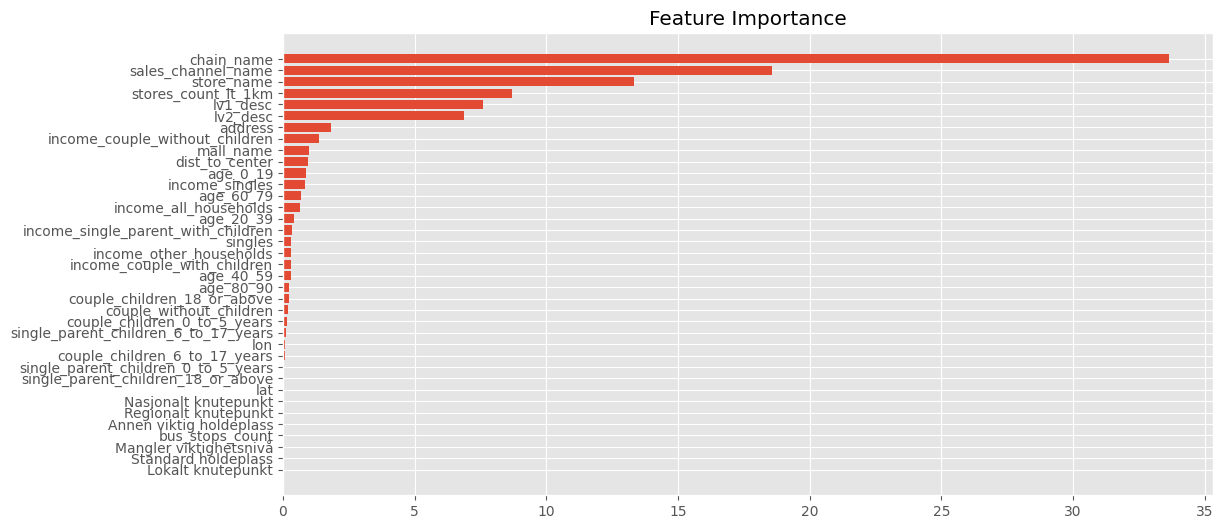

In [ ]:
feature_importance = cbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_cb.columns)[sorted_idx])
plt.title('Feature Importance')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

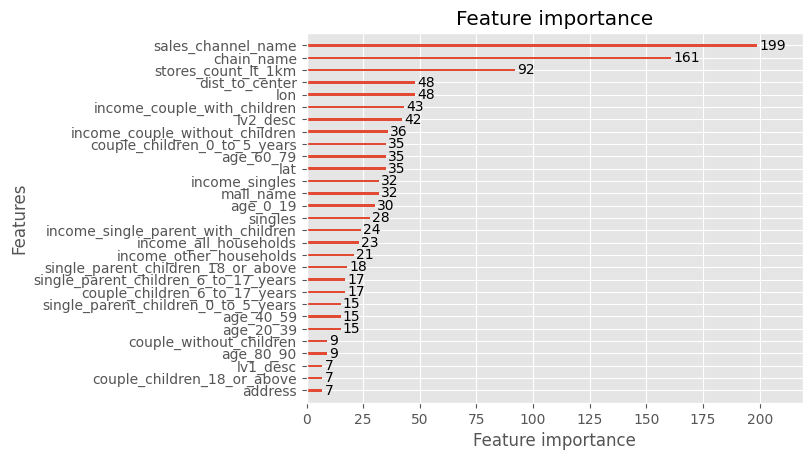

In [ ]:
lgb.plot_importance(lgbm)

## 5.2 SHAP

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(cbm)

train_pool, _ = get_cb_pools()
shap_values = explainer.shap_values(train_pool)

shap.force_plot(explainer.expected_value, shap_values[0:100, :], X_train_cb.iloc[0:100, :])

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(lgbm)

dtrain, _ = get_lgb_dmatrices()
shap_values = explainer.shap_values(X_train_lgb)

shap.force_plot(explainer.expected_value, shap_values[0:200, :], X_train_lgb.iloc[0:200, :])

NameError: name 'shap' is not defined

# Old code and text below this line -------------------------------------

Using this, we can gain an intuition for what kind of businesses with which we are working by identifying all the unique descriptions for each hierarchy level.

**Observation**: At a glance it looks as though the `sales_channel_name` column might be redundant. All of it's values in the head subset match `lv4_desc_y`. This should be relatively easy to check whilst inspecting Plaace hierarchy descriptions.

As a sanity check we print out the number of unique level 4 categories, as the introduction notebook said there should be 109 of them.

In [ ]:
#Merge all the data
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
stores_with_grunnkrets = df_all.merge(spatial, how='left', on='grunnkrets_id')

stores_with_grunnkrets.head()
#sum(stores_with_grunnkrets["municipality_name"].isnull())

stores_with_grunnkrets = stores_with_grunnkrets.drop("address", axis = 1)
stores_with_grunnkrets = stores_with_grunnkrets.drop("mall_name", axis = 1)
stores_with_grunnkrets = stores_with_grunnkrets.drop("chain_name", axis = 1)
stores_with_grunnkrets[stores_with_grunnkrets.isna().any(axis=1)]
sum(stores_with_grunnkrets["grunnkrets_name"].isnull())

54

In [ ]:
lv1_descs = df_all['lv1_desc_y'].drop_duplicates()
lv1_descs = lv1_descs.T.drop_duplicates().T
print(f"Number of unique level one descriptions:", len(lv1_descs), ".")

lv2_descs = df_all['lv2_desc_y'].drop_duplicates()
lv2_descs = lv2_descs.T.drop_duplicates().T
print(f"Number of unique level 2 categories: ", len(lv2_descs), ".")

lv3_descs = df_all['lv3_desc_y'].drop_duplicates()
lv3_descs = lv3_descs.T.drop_duplicates().T
print(f"Number of unique level 3 categories: ", len(lv3_descs), ".")


lv4_descs = df_all['lv4_desc_y'].drop_duplicates()
lv4_descs = lv4_descs.T.drop_duplicates().T
print(f"Number of unique level 4 categories: ", len(lv4_descs), ".")


KeyError: 'lv1_desc_y'

This seems off. The introduction notebook mentions 109 different level 4 categories.

Let's check whether the rest feature in the extra data set.

In [ ]:
df_extra = pd.read_csv("data/stores_extra.csv")
df_extra = df_extra.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
df_full = pd.concat([df_all, df_extra], ignore_index=True)

lv1_descs = df_full['lv1_desc_y'].drop_duplicates()
lv1_descs = lv1_descs.T.drop_duplicates().T
print(f"Number of unique level one descriptions:", len(lv1_descs), ".")

lv2_descs = df_full['lv2_desc_y'].drop_duplicates()
lv2_descs = lv2_descs.T.drop_duplicates().T
print(f"Number of unique level 2 categories: ", len(lv2_descs), ".")

lv3_descs = df_full['lv3_desc_y'].drop_duplicates()
lv3_descs = lv3_descs.T.drop_duplicates().T
print(f"Number of unique level 3 categories: ", len(lv3_descs), ".")


lv4_descs = df_full['lv4_desc_y'].drop_duplicates()
lv4_descs = lv4_descs.T.drop_duplicates().T
print(f"Number of unique level 4 categories: ", len(lv4_descs), ".")

#NOTE to self: Check if the error disappears when only concatenating the extra set with the training set.




InvalidIndexError: Reindexing only valid with uniquely valued Index objects